In [2]:
import sys
import string

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import SimpleRNN, GRU, LSTM

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

# Домашнее задание №1


## Часть 1 - Генерация текста 

## Предобработка данных

In [2]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

In [3]:
Letters = string.ascii_uppercase #я не знаю в чем мем, но иначе не работает

test = ""
for string in text:
    test += string.lower()

text = test

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in Letters]), 'Uppercase letters are present'
print('Отлично!')

Отлично!


In [4]:
tokens = sorted(list(set(text)))
print(tokens)

['\n', ' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
idx_to_token = dict(enumerate(tokens))
token_to_idx = dict((v,k) for k,v in idx_to_token.items())
print(token_to_idx)

{'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, ':': 9, ';': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}


*Комментарий: т.к. у нас всего 38 различных токенов, в этот раз воспользуемся one-hot encoding'ом.*


## Построение модели.

In [64]:
maxlen = 25

model = Sequential()
model.add(SimpleRNN(64, input_shape=(maxlen, len(tokens))))
model.add(Dense(len(tokens), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, 64)                6592      
_________________________________________________________________
dense_16 (Dense)             (None, 38)                2470      
Total params: 9,062
Trainable params: 9,062
Non-trainable params: 0
_________________________________________________________________


In [65]:
sentences = []
next_chars = []

for k in range(0, len(text)-maxlen, maxlen):
    sentences.append(text[k:k+maxlen])
    next_chars.append(text[k+maxlen])
    
x = np.zeros((len(sentences), maxlen, len(tokens)), dtype=np.integer)
y = np.zeros((len(sentences), len(tokens)), dtype=np.integer)
print(x.shape, y.shape)
    
for i,j in enumerate(sentences):
    for k, token in enumerate(j):
        x[i, k, token_to_idx[token]] = 1
    y[i, token_to_idx[next_chars[i]]] = 1

history = model.fit(x, y, batch_size=32, epochs=20, validation_split=0.1)

(4008, 25, 38) (4008, 38)
Epoch 1/20
113/113 [==============================] - 1s 6ms/step - loss: 3.0004 - val_loss: 2.8413
Epoch 2/20
113/113 [==============================] - 1s 5ms/step - loss: 2.5405 - val_loss: 2.4408
Epoch 3/20
113/113 [==============================] - 1s 5ms/step - loss: 2.3249 - val_loss: 2.3940
Epoch 4/20
113/113 [==============================] - 1s 5ms/step - loss: 2.2422 - val_loss: 2.3464
Epoch 5/20
113/113 [==============================] - 1s 5ms/step - loss: 2.1827 - val_loss: 2.3617
Epoch 6/20
113/113 [==============================] - 1s 5ms/step - loss: 2.1181 - val_loss: 2.3305
Epoch 7/20
113/113 [==============================] - 1s 5ms/step - loss: 2.0610 - val_loss: 2.3274
Epoch 8/20
113/113 [==============================] - 1s 5ms/step - loss: 2.0202 - val_loss: 2.3001
Epoch 9/20
113/113 [==============================] - 1s 5ms/step - loss: 1.9715 - val_loss: 2.2792
Epoch 10/20
113/113 [==============================] - 1s 5ms/step - loss:

Постройте график функции потерь в зависимости от номера эпохи.

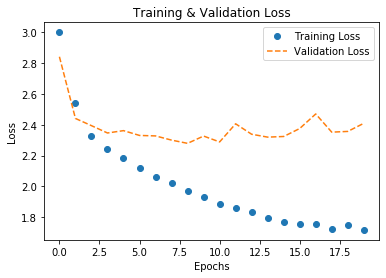

In [66]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(len(loss_values))

plt.plot(epochs, loss_values, 'o', label='Training Loss')
plt.plot(epochs, val_loss_values, '--', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [67]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(diversity, length, model):
    print()
    print('...Генерация текста. Температура: ', diversity)
    start_index = np.random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    sys.stdout.write(generated)
    for i in range(length):
        x_pred = np.zeros((1, maxlen, len(tokens)))
        for t, char in enumerate(sentence):
            x_pred[0, t, token_to_idx[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0] #Вектор вероятностей, полученный с помощью модели
        next_index = sample(preds, diversity) # Выбираем индекс
        next_char = idx_to_token[next_index] #Выбираем символ из словаря 

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

print(generate_text(0.4, 500, model))


...Генерация текста. Температура:  0.4
ch public manners breeds.
  and soth my will uris my my mave dround of that so sthy 
  the so that with my live do storewne i bear with my live, and then my prach wealt deve,
  and then more dich wrich whing and sor whing and bar when mo have drest shour rould dave then my live, and but hearthy picg my veve,
  and then prich woth arle dove thy seve,
  and sor whing and and the the priched so live droun dor whing and sore
  and then so houst thing art ar wotling,
  and bractuoun love thing and sore
  and then efar so liv
None


## Более поэтичная модель

In [79]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(tokens))))
model.add(Dropout(0.2))
model.add(Dense(len(tokens), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               85504     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 38)                4902      
Total params: 90,406
Trainable params: 90,406
Non-trainable params: 0
_________________________________________________________________


In [83]:
history = model.fit(x, y, batch_size=128, epochs=40, shuffle=True, validation_split=0.1)

Epoch 1/40
29/29 [==============================] - 1s 42ms/step - loss: 1.8625 - val_loss: 2.1810
Epoch 2/40
29/29 [==============================] - 1s 41ms/step - loss: 1.7701 - val_loss: 2.2249
Epoch 3/40
29/29 [==============================] - 1s 41ms/step - loss: 1.6783 - val_loss: 2.1639
Epoch 4/40
29/29 [==============================] - 1s 41ms/step - loss: 1.5667 - val_loss: 2.2474
Epoch 5/40
29/29 [==============================] - 1s 48ms/step - loss: 1.4531 - val_loss: 2.4188
Epoch 6/40
29/29 [==============================] - 1s 43ms/step - loss: 1.3364 - val_loss: 2.4395
Epoch 7/40
29/29 [==============================] - 1s 47ms/step - loss: 1.2084 - val_loss: 2.4679
Epoch 8/40
29/29 [==============================] - 1s 42ms/step - loss: 1.0998 - val_loss: 2.5668
Epoch 9/40
29/29 [==============================] - 1s 41ms/step - loss: 0.9938 - val_loss: 2.5862
Epoch 10/40
29/29 [==============================] - 1s 42ms/step - loss: 0.8873 - val_loss: 2.7865
Epoch 11/

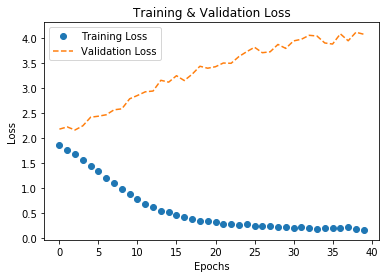

In [84]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(len(loss_values))

plt.plot(epochs, loss_values, 'o', label='Training Loss')
plt.plot(epochs, val_loss_values, '--', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
 
plt.show()

In [85]:
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for temp in temperatures:
    generate_text(temp, 500, model)


...Генерация текста. Температура:  0.1
der the blow of thralled fore thou down pave pring my have thy lessse mave prt and thought:
  the prrptaus serartound of alfors,
  and hupst digh thy buast, that dedould stall that beart that dedorghand comme.
  and callime,
  theno  thene ell thise thou, that sest lave and lichie ind thy beatt of meme dighuthoun baat of althend,
  and callime de thing my heartith all that beart,
  and lasss me call that beart that in oweet siine to mous,
  a dore urt on althen bar llong,
  and caksing ere thy faust thou artwould that d

...Генерация текста. Температура:  0.2

  will be a tatter'd weele thingseno howeethen,
  ald that beating the pest beat rame thy farst thin thou dotn loveny brrgit of thou dotn allimen now thy mime, mellen now pith my huast,
  and thous stime, sorell the pest cammy nower;
  weet oull this rageveny farn, thy farst thou artwould thou doth loven no  have pring my haase thy farst dith thy baant of meme frorgh- commy,
  and licks sor

Мне такие поэмы уже кажутся правдоподобными, хотя модель переобучается судя по росту валидационного лосса, на тексте этого не видно совсем

Я крутила и количество и размеры слоёв, и количество эпох, получить одновременно краисвые тексты и удобоваримый график лосс не удалось

## Сохранение и загрузка модели

In [95]:
model.save('LSTM')
model = load_model('LSTM')
print(generate_text(0.1, 500, model))

INFO:tensorflow:Assets written to: LSTM/assets

...Генерация текста. Температура:  0.1
he basest weed outbraves sime,
  then mend more that redous sormeftling, mere pest barten, of meenest thie all thise-thoun barty fould that dedould stall that beart that in of meevest thing my fals thou ward, outhat,
  and calsing of lime,
  the prrcts me cemy dight dith thy beatt that beart,
  and laksing my furmmy,
  ast lever saing thought:
  the keove thee the heast this art thee.
  whine the pest beat right dith and the promy meme diss thou dotn soall the woull thing end comme.
  sorrn sould shall my hearty, as wer
None


## Часть 2 - Применение методов NLP

1. Подготовка __[10%]__:
    - Скачайте данные, проведите первоначальные EDA: баланс классов, пересечение классов и т.д. 
    - Придумайте и обоснуйте стратегию валидации. 
    - Сделайте предбработку данных. Оцените что требуется делать с символами, заглавными буквами. Проведите лемматизацию или стеминг.

In [3]:
train = pd.read_csv("./comments/train.csv", encoding = "ISO-8859-1")
test = pd.read_csv("./comments/test.csv", encoding = "ISO-8859-1")
train = train.drop(['id'], axis=1)

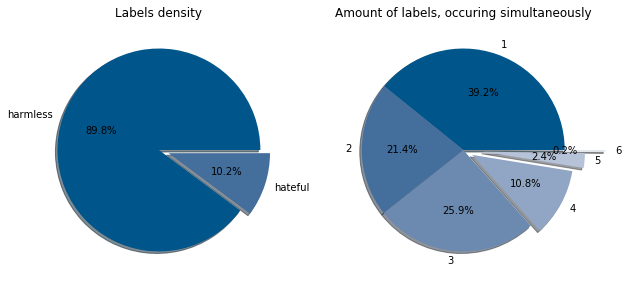

In [4]:
colors=['#00558a', '#446f9d', '#6c8ab0', '#91a6c4', '#b5c2d7', '#dae0eb']

train_ = train.drop(['comment_text'], axis=1)
train_['label_number'] = 0
train_['label_number'] = train.sum(axis=1)
train_.head(10)

toxic_num = np.count_nonzero(train_.label_number)

plt.subplots(figsize=(10,5))
plt.subplot(121)
plt.title("Labels density")
plt.pie([len(train_)-toxic_num, toxic_num], labels=['harmless','hateful'], \
        colors=colors[:2], explode=(0, 0.1), autopct='%1.1f%%', shadow=True)

plt.subplot(122)
pst = train_.groupby('label_number').size()
pst[1:].plot(kind='pie', colors=colors, explode=(0,0,0,0.1,0.2,0.4),\
             shadow=True, autopct='%1.1f%%')
plt.title("Amount of labels, occuring simultaneously")
plt.ylabel("")
plt.xlabel("")
plt.show()

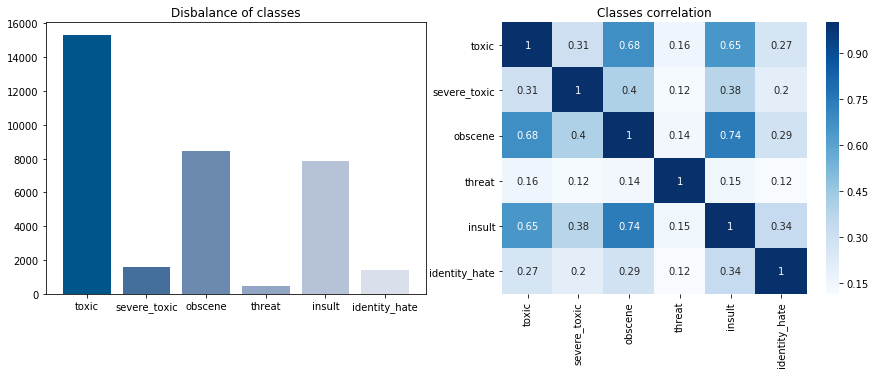

In [5]:
classes = []
train_ = train_.drop(['label_number'], axis=1)

for tag in train_.columns:
    classes.append(train_[tag].sum())

corr = train_.corr()
    
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.title("Disbalance of classes")
plt.bar(train_.columns, classes, color=colors)

plt.subplot(122)
plt.title("Classes correlation")
sns.heatmap(corr, annot=True, cmap='Blues')
plt.show()

In [6]:
import re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def clean_comment(comment):
    comment = re.sub(r"@[A-Za-z0-9]+", ' ', comment)
    comment = re.sub(r"https?://[A-Za-z0-9./]+", ' ', comment) #delete links
    comment = re.sub(r"[^a-zA-Z.!?']", ' ', comment) #and other symbols
    comment = re.sub(r" +", ' ', comment) #and additional spaces
    #capitalization heats comments up, so I keep it
    return comment

x_train = train['comment_text'].apply(lambda x: clean_comment(x))
x_test = test['comment_text'].apply(lambda x: clean_comment(x))
train_label = train.drop(['comment_text'], axis=1)

Так как некоторые классы сильно коррелируют <br>
Беру старый добрый сплит без прекрас, разве что шафлю иногда

2. Примените любой Embedding (word2vec или Glove) __[5%]__

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, Input, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split

tokenizer = Tokenizer(num_words = 50000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

train_padded = pad_sequences(x_train, maxlen=100)
test_padded = pad_sequences(x_test, maxlen=100)

3. Постройте следующие модели (для каждой необходимо самостоятельно выбрать оптимальное количество слоеев и архитектуру, оценить качество, переобученность, построить кривые обучения и валидации, сделать выводы по примению модели):
    - Одномерные свертки __[20%]__
    - LSTM или GRU __[20%]__
    - Bidirectional LSTM __[20%]__   

In [10]:
## одномерные свертки
model = Sequential()
model.add(Embedding(50000, 128))
model.add(Conv1D(32, kernel_size = 3, padding = "valid"))
model.add(GlobalMaxPooling1D())
model.add(Dense(units = 6, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         6400000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          12320     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 6,412,518
Trainable params: 6,412,518
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
x_train, x_val, y_train, y_val = train_test_split(train_padded, train_label, \
                                        shuffle = True, random_state = 123)
model.fit(x_train, y_train, batch_size = 32, epochs = 1, validation_data = (x_val, y_val))

3740/3740 [==============================] - 314s 84ms/step - loss: 0.0667 - auc: 0.9671 - val_loss: 0.0492 - val_auc: 0.9801


In [12]:
predict = model.predict(test_padded)
target_cols = np.array(['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate'])
final_predict_test = pd.concat([pd.DataFrame(predict, columns=target_cols)], 1)
t1 = test['id']
final_predict_test = pd.concat([t1,final_predict_test],1)
final_predict_test.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.991767,0.203469,0.955996,0.046824,0.879343,0.185859
1,0000247867823ef7,0.000928,0.000038,0.000250,0.000125,0.000409,0.000185
2,00013b17ad220c46,0.024505,0.000362,0.002930,0.000917,0.003660,0.000726
3,00017563c3f7919a,0.002213,0.000204,0.000464,0.000211,0.001276,0.000318
4,00017695ad8997eb,0.013406,0.000571,0.003547,0.001452,0.002472,0.000835


In [13]:
final_predict_test.to_csv('hw_1_BoriskovaEYU.csv', index=False)

Свертка сработала лучше всего остального - 0.96728

In [163]:
## LSTM
model = Sequential()
model.add(Embedding(50000, 128))
model.add(LSTM(units = 64, dropout = 0.2,return_sequences=True))
model.add(LSTM(units = 64, dropout = 0.2))
model.add(Dense(units = 6, activation = 'sigmoid'))
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 128)         6400000   
_________________________________________________________________
lstm_22 (LSTM)               (None, None, 64)          49408     
_________________________________________________________________
lstm_23 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_34 (Dense)             (None, 6)                 390       
Total params: 6,482,822
Trainable params: 6,482,822
Non-trainable params: 0
_________________________________________________________________


In [118]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
x_train, x_val, y_train, y_val = train_test_split(train_padded, train_label, \
                                        shuffle = True, random_state = 123)
model.fit(x_train, y_train, batch_size = 32, epochs = 1, validation_data = (x_val, y_val))

3740/3740 [==============================] - 779s 208ms/step - loss: 0.0699 - auc: 0.9594 - val_loss: 0.0497 - val_auc: 0.9790


In [119]:
predict = model.predict(test_padded)
target_cols = np.array(['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate'])
final_predict_test = pd.concat([pd.DataFrame(predict, columns=target_cols)], 1)
t1 = test['id']
final_predict_test = pd.concat([t1,final_predict_test],1)
final_predict_test.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.983961,0.266412,0.940029,0.052926,0.800918,0.157120
1,0000247867823ef7,0.006120,0.000042,0.000835,0.000141,0.000419,0.000204
2,00013b17ad220c46,0.028059,0.000118,0.003021,0.000477,0.001549,0.000657
3,00017563c3f7919a,0.021568,0.000082,0.002268,0.000345,0.001043,0.000445
4,00017695ad8997eb,0.022470,0.000090,0.002442,0.000351,0.001196,0.000496


In [148]:
final_predict_test.to_csv('hw_1_BoriskovaEYU.csv', index=False)

Применимость LSTM здесь очевидна, так как моя сеть обучается быстро(всего за одну эпоху) тут и кривых строить не из чего <br>
Late Submission выдал 0.96149 - что я считаю очень хорошо

In [146]:
##bidirectional LSTM
from keras.layers import Bidirectional, Flatten
model = Sequential()
model.add(Embedding(50000, 128))
model.add(Bidirectional(LSTM(units = 64, dropout = 0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(units = 64, dropout = 0.2)))
model.add(Dense(units = 6, activation = 'sigmoid'))
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 128)         6400000   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 128)         98816     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 774       
Total params: 6,598,406
Trainable params: 6,598,406
Non-trainable params: 0
_________________________________________________________________


In [147]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
x_train, x_val, y_train, y_val = train_test_split(train_padded, train_label, \
                                        shuffle = True, random_state = 123)
model.fit(x_train, y_train, batch_size = 32, epochs = 1, validation_data = (x_val, y_val))

3740/3740 [==============================] - 952s 255ms/step - loss: 0.0686 - auc: 0.9595 - val_loss: 0.0497 - val_auc: 0.9762


In [149]:
predict = model.predict(test_padded)
target_cols = np.array(['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate'])
final_predict_test = pd.concat([pd.DataFrame(predict, columns=target_cols)], 1)
t1 = test['id']
final_predict_test = pd.concat([t1,final_predict_test],1)
final_predict_test.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.977689,0.248755,0.941777,0.080713,0.867671,0.133474
1,0000247867823ef7,0.002898,0.000075,0.000616,0.000133,0.000779,0.000281
2,00013b17ad220c46,0.010508,0.000212,0.001878,0.000390,0.002611,0.000911
3,00017563c3f7919a,0.004293,0.000095,0.000707,0.000189,0.000934,0.000418
4,00017695ad8997eb,0.029205,0.000356,0.004100,0.000892,0.006436,0.002545


In [150]:
final_predict_test.to_csv('hw_1_BoriskovaEYU.csv', index=False)

Bidirectional LSTM показал себя чуть хуже - 0.96077 <br>
Однако все равно применим и очень успешно

4. Попробуйте применить к этой задаче BERT или GPT-2. Выбор оптимального количества слоеев и архитектура на ваш вкус (но не забудьте обосновать его). Оцените качетво и другие параметры работы модели. __[25%]__

In [152]:
#! pip install pytorch-transformers

x_train, x_val, y_train, y_val = train_test_split(train_padded, train_label, \
                                        shuffle = True, random_state = 123)

#train_inputs = torch.tensor(x_train)
#train_labels = torch.tensor(y_train)

#val_inputs = torch.tensor(x_val)
#val_labels = torch.tensor(y_val)

from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

100%|██████████| 440473133/440473133 [42:52<00:00, 171231.36B/s] 


Берт так и не заработал, но я пыталась....

5. Основываясь на полученных результатах, сделайте свою лучшую модель и сделайте Late Submission на тестовых данных [challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Не забудьте <u>приложить</u> скриншот с Вашим скором. Скриншот вставьте прямо в ноутбук с решением или выведите в stdout. 

На одномерной свертке скор уже космический <br>
Я могла бы придумывать еще модели, но смысл, если уже почти 0.97

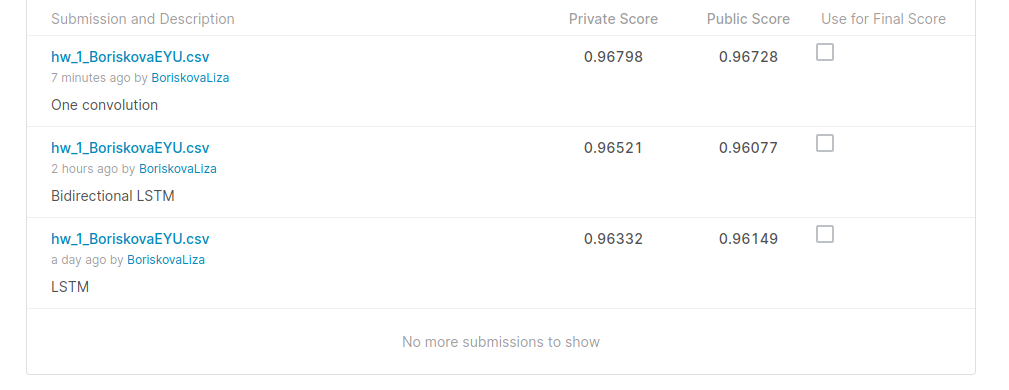

In [15]:
from IPython.display import Image
Image("pic.png")

## Часть 3 - Attention Basics

Original notebook is provided by Udacity at [github](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/attention/Attention_Basics.ipynb) 

In this notebook, we look at how attention is implemented. We will focus on implementing attention in isolation from a larger model. That's because when implementing attention in a real-world model, a lot of the focus goes into piping the data and juggling the various vectors rather than the concepts of attention themselves.

We will implement attention scoring as well as calculating an attention context vector.

## Attention Scoring
### Inputs to the scoring function
Let's start by looking at the inputs we'll give to the scoring function. We will assume we're in the first step in the decoding phase. The first input to the scoring function is the hidden state of decoder (assuming a toy RNN with three hidden nodes -- not usable in real life, but easier to illustrate):

In [27]:
dec_hidden_state = [5,1,20]

Let's visualize this vector:

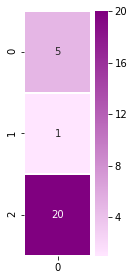

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(dec_hidden_state)), annot=True, cmap=sns.light_palette("purple", as_cmap=True), linewidths=1)

Our first scoring function will score a single annotation (encoder hidden state), which looks like this:

In [29]:
annotation = [3,12,45]

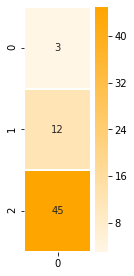

In [30]:
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(annotation)), annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

### IMPLEMENT: Scoring a Single Annotation
Let's calculate the dot product of a single annotation. NumPy's [dot()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) is a good candidate for this operation

In [33]:
def single_dot_attention_score(dec_hidden_state, enc_hidden_state):
    return np.dot(dec_hidden_state, enc_hidden_state)
    
single_dot_attention_score(dec_hidden_state, annotation)

927


### Annotations Matrix
Let's now look at scoring all the annotations at once. To do that, here's our annotation matrix:

In [34]:
annotations = np.transpose([[3,12,45], [59,2,5], [1,43,5], [4,3,45.3]])

And it can be visualized like this (each column is a hidden state of an encoder time step):

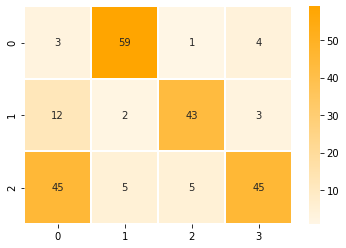

In [35]:
ax = sns.heatmap(annotations, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

### IMPLEMENT: Scoring All Annotations at Once
Let's calculate the scores of all the annotations in one step using matrix multiplication. Let's continue to us the dot scoring method

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/attention/images/scoring_functions.png?raw=true" />

To do that, we'll have to transpose `dec_hidden_state` and [matrix multiply](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html) it with `annotations`.

In [37]:
def dot_attention_score(dec_hidden_state, annotations):
    return np.matmul(np.transpose(dec_hidden_state), annotations)
    
attention_weights_raw = dot_attention_score(dec_hidden_state, annotations)
attention_weights_raw

array([927., 397., 148., 929.])

Looking at these scores, can you guess which of the four vectors will get the most attention from the decoder at this time step?

## Softmax
Now that we have our scores, let's apply softmax:
<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/attention/images/softmax.png?raw=true" />

In [38]:
def softmax(x):
    x = np.array(x, dtype=np.float128)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0) 

attention_weights = softmax(attention_weights_raw)
attention_weights

array([1.19202922e-001, 7.94715151e-232, 5.76614420e-340, 8.80797078e-001],
      dtype=float128)

Even when knowing which annotation will get the most focus, it's interesting to see how drastic softmax makes the end score become. The first and last annotation had the respective scores of 927 and 929. But after softmax, the attention they'll get is 0.12 and 0.88 respectively.

# Applying the scores back on the annotations
Now that we have our scores, let's multiply each annotation by its score to proceed closer to the attention context vector. This is the multiplication part of this formula (we'll tackle the summation part in the latter cells)

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/attention/images/Context_vector.png?raw=true" />

In [39]:
def apply_attention_scores(attention_weights, annotations):
    return attention_weights * annotations

applied_attention = apply_attention_scores(attention_weights, annotations)
applied_attention

array([[3.57608766e-001, 4.68881939e-230, 5.76614420e-340,
        3.52318831e+000],
       [1.43043506e+000, 1.58943030e-231, 2.47944200e-338,
        2.64239123e+000],
       [5.36413149e+000, 3.97357575e-231, 2.88307210e-339,
        3.99001076e+001]], dtype=float128)

Let's visualize how the context vector looks now that we've applied the attention scores back on it:

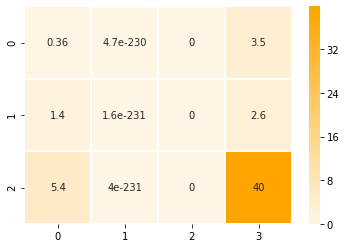

In [40]:
# Let's visualize our annotations after applying attention to them
ax = sns.heatmap(applied_attention, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

Contrast this with the raw annotations visualized earlier in the notebook, and we can see that the second and third annotations (columns) have been nearly wiped out. The first annotation maintains some of its value, and the fourth annotation is the most pronounced.

# Calculating the Attention Context Vector
All that remains to produce our attention context vector now is to sum up the four columns to produce a single attention context vector



In [41]:
def calculate_attention_vector(applied_attention):
    return np.sum(applied_attention, axis=1)

attention_vector = calculate_attention_vector(applied_attention)
attention_vector

array([ 3.88079708,  4.0728263 , 45.26423912], dtype=float128)

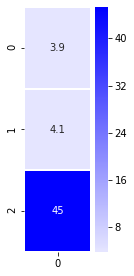

In [42]:
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(attention_vector)), annot=True, cmap=sns.light_palette("Blue", as_cmap=True), linewidths=1)

Now that we have the context vector, we can concatenate it with the hidden state and pass it through a hidden layer to produce the the result of this decoding time step.

__Готовый ноутбук загрузите в эту форму: [http://bit.ly/ml_hw_2021](http://bit.ly/ml_hw_2021)__


